In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


In [ ]:
env = gym.make('CartPole-v0')


In [3]:
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)
    

In [4]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_size=4, hidden_layer_size=64):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, 1)
    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.fc2(torch.nn.functional.relu(self.fc1(x)))

In [5]:
def reinforce(policy, policy_optimizer, value_net, value_net_optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):    
    scores_deque = deque(maxlen=100)
    scores = []
    policy_loss_ = []
    value_net_loss = []
    for e in range(n_episodes):
        saved_log_probs = []
        rewards = []
        values = []
        states = []
        env.reset()
        state = env.state        
    
        for t in range(max_t):
            action, log_prob = policy.act(state)
            value = value_net(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _= env.step(action)
            rewards.append(reward)
            values.append(value)
             
            if done:
                break
            
        R = rewards
        i = len(rewards)-2
        while i>=0:
          R[i] = R[i] + R[i+1]
          i= i-1

        scores.append(R[0])
                       
        for i, log_prob in enumerate(saved_log_probs):
            policy_loss_.append(-log_prob * (R[i]-values[i]))

        for i,value in enumerate(values):
            value_net_loss.append((values[i] - R[i])**2)
    
    #print(len(policy_loss_))
    #print(policy_loss_)
    policy_loss = torch.cat(policy_loss_).sum()  
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    value_net_loss = torch.cat(values).mean()
    value_net_optimizer.zero_grad()
    value_net_loss.backward()
    value_net_optimizer.step()

    return np.mean(scores)


In [6]:

policy = Policy()
policy_optimizer = optim.Adam(policy.parameters(), lr=1e-2)
value_net = ValueNet()
value_net_optimizer = optim.Adam(value_net.parameters(), lr=1e-2)
rewards = []

for itr in range(500):
    print("Running iteration: ", itr)
    rewards.append(reinforce(policy, policy_optimizer, value_net, value_net_optimizer, n_episodes=1000, max_t = 500))

x_axis = [i for i in range(1, 501)]
plt.plot(x_axis, rewards)  


Running iteration:  0
Running iteration:  1
Running iteration:  2
Running iteration:  3
Running iteration:  4
Running iteration:  5
Running iteration:  6
Running iteration:  7
Running iteration:  8
Running iteration:  9
Running iteration:  10
Running iteration:  11
Running iteration:  12
Running iteration:  13
Running iteration:  14
Running iteration:  15
Running iteration:  16
Running iteration:  17
Running iteration:  18
Running iteration:  19
Running iteration:  20
Running iteration:  21
Running iteration:  22
Running iteration:  23
Running iteration:  24
Running iteration:  25
Running iteration:  26
Running iteration:  27
Running iteration:  28
Running iteration:  29
Running iteration:  30
Running iteration:  31
Running iteration:  32
Running iteration:  33
Running iteration:  34
Running iteration:  35
Running iteration:  36
Running iteration:  37
Running iteration:  38
Running iteration:  39
Running iteration:  40
Running iteration:  41
Running iteration:  42
Running iteration:  4

KeyboardInterrupt: ignored

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Policy Gradient with Baseline')

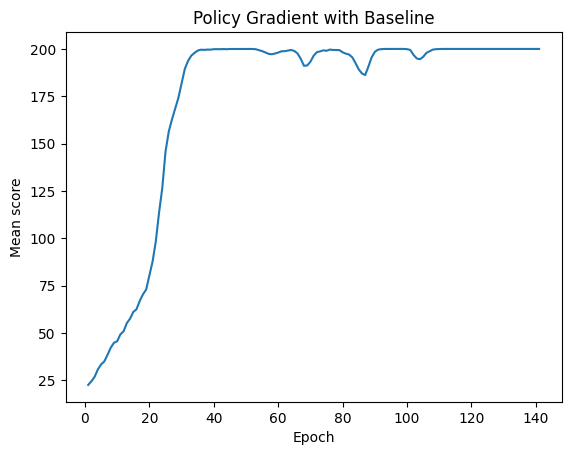

In [9]:
x_axis = [i for i in range(1, 142)]
plt.plot(x_axis, rewards)  
plt.xlabel('Epoch')
plt.ylabel('Mean score')
plt.title('Policy Gradient with Baseline')